##### Import Libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch 
pd.options.mode.chained_assignment = None  # default='warn'

import quantstats as qs
import yfinance as yf

c:\Users\mathe\mambaforge\envs\qfml_updated\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Define tickers used

In [2]:
tickers = ["EWA", "EWK", "EWO", "EWC", "EWQ", "EWG", "EWH", "EWI", "EWJ", "EWM", "EWW", 
                   "EWN", "EWS", "EWP", "EWD", "EWL", "EWY", "EZU", "EWU", "EWZ", "EWT",]

Split the data into training and validation sets

In [3]:
etfPrices = pd.DataFrame()
count=0
for ticker in tickers:
    etfPrices[count] = yf.download(ticker, start = '2000-08-01', end='2008-1-1', auto_adjust=True).Close
    count+=1

etfPricesTrain = etfPrices[:-100].dropna()
etfPricesVaidation = etfPrices[-100:].dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [4]:
etfPricesTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-01,3.663007,6.485519,4.528478,9.979506,14.198685,12.987756,6.540592,19.761650,37.929760,8.209232,...,13.794388,6.118052,10.825949,11.642289,10.808950,14.086654,21.718874,15.688077,8.340686,16.272770
2000-08-02,3.685480,6.485519,4.493098,10.260177,14.103607,12.884948,6.698580,19.562546,37.929760,8.123718,...,13.721787,6.169466,10.772751,11.517633,10.683747,14.180568,21.439981,15.688077,8.232362,16.272770
2000-08-03,3.730425,6.426019,4.528478,10.197806,13.691595,12.713606,6.856563,19.114555,37.755772,8.209232,...,13.576585,6.169466,10.666353,11.218476,10.600279,14.180568,20.742743,15.534773,8.178202,16.272770
2000-08-04,3.752897,6.545021,4.528478,10.291364,13.818366,12.782142,6.856563,19.114555,37.929760,8.465772,...,13.649188,6.118052,10.799348,11.343128,10.725479,13.992745,21.108797,15.841385,8.503167,16.216465
2000-08-07,3.797842,6.574772,4.599235,10.447292,14.040223,12.919219,6.982954,19.612322,38.103741,8.380260,...,13.794388,6.220879,10.852549,11.517633,10.767216,13.523191,21.265663,15.943583,8.503167,16.103849


#### Heirarchical Risk Parity Implementation

In [5]:
# Code given in part from Building Diversified Portfolios 
# that Outperform Out-of-Sample by Marcos Lopez de Prado
# Method getQuasiDiag
# This method sorts a given matrix and places the largest values
# on the diagonal
# @param link The linkage matrix that defines the hierarchical structure
#        of the covariance matrix and the distance between assets
# @returns a list of the assets sorted by distance
def getQuasiDiag(link):
    # convert the distances to integers
    link=link.astype(int)
    # The index to sort on
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    # Number of items (assets) in the linkage matrix
    numItems=link[-1,3] 
    # While we haven't added each asset to the output list
    while sortIx.max()>=numItems:
        # extend the output list
        sortIx.index=range(0,sortIx.shape[0]*2,2) 
        # find clusters to sort on
        df0=sortIx[sortIx>=numItems]
        # i and j are the indexes of the cluster assets in the linkage matirx
        i = df0.index
        j = df0.values-numItems
        # get the first asset
        sortIx[i] = link[j,0] 
        # update the cluster list
        df0=pd.Series(link[j,1],index=i+1)
        # add the cluster (assets) to the output list
        sortIx = pd.concat([sortIx, df0], axis=0, join='outer')
        # sort the output list to be index sequential
        sortIx=sortIx.sort_index() 
        # reindex to accomodate sort
        sortIx.index=range(sortIx.shape[0]) 
    # return the list of assets by distance
    return sortIx.tolist()

In [6]:
# Method getClusterVar
#   This method calculates the variance for a given cluster
#   @param cov The covariance matrix of all assets
#   @param cItems The list containing the assets in the cluster
#   @returns a numerical value for the variance of the cluster
def getClusterVar(cov,cItems):
    # remove constituents not in bisection from cov matrix
    cov = cov.filter(items=cItems, axis=0)
    cov = cov.filter(items=cItems, axis=1)

    # calculate the weights for the cluster
    w = 1/np.diag(cov) * (1/np.sum(1/np.diag(cov)))

    # return the variance of the cluster
    return w.T@cov@w

In [7]:
# Code given in part from Building Diversified Portfolios 
# that Outperform Out-of-Sample by Marcos Lopez de Prado
# Method getRecBipart
#     This method splits the covariance matrix in half recursively and
#     and calulcates optimal asset weights based on the clusters in each split
#     @param cov The covariance matrix of all assets
#     @param sortIx a list of assets sorted by distance
#     @returns allocation weights for each asset
def getRecBipart(cov,sortIx):
    # this is the output variable for the allocation weights
    w=pd.Series(1,index=sortIx)
    # create a list to split the sorted hierarchy into clusters
    cItems=[sortIx] 
    while len(cItems)>0:
        # This line creates bisections of the sorted hierarchy
        # to form adjacent clusters
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)//2),(len(i)//2,len(i))) if len(i)>1] 
        
        # loop through each set of clusters
        for i in range(0,len(cItems),2): # parse in pairs
            # get clusters for this run
            cItems0=cItems[i] 
            cItems1=cItems[i+1] 
            # here we get the variance for each cluster
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            # define a splitting factor alpha
            alpha=1-cVar0/(cVar0+cVar1)
            # re-scale the weights 
            w[cItems0]*=alpha 
            w[cItems1]*=1-alpha 
    return w

In [8]:
# Code given in part from Building Diversified Portfolios 
# that Outperform Out-of-Sample by Marcos Lopez de Prado

x = etfPricesTrain
# get the correlation and covariance matrix from the 
# training set
covarianceMatrix,corrMatrix=x.cov(),x.corr() 
# calculate a distance matrix using the correlation matrix
distMatrix = ((1-corrMatrix)/2.)**.5 
# create the heirarchy that defines the asset switching for the
# model
linkMatrix = sch.linkage(distMatrix,'single') 
linkMatrix

In [9]:
# sort the matrix to get the largest values on the diagonal
sortedMatrix = getQuasiDiag(linkMatrix)
sortedMatrix

[20, 8, 9, 16, 11, 5, 6, 14, 4, 17, 15, 18, 12, 0, 2, 7, 1, 13, 10, 3, 19]

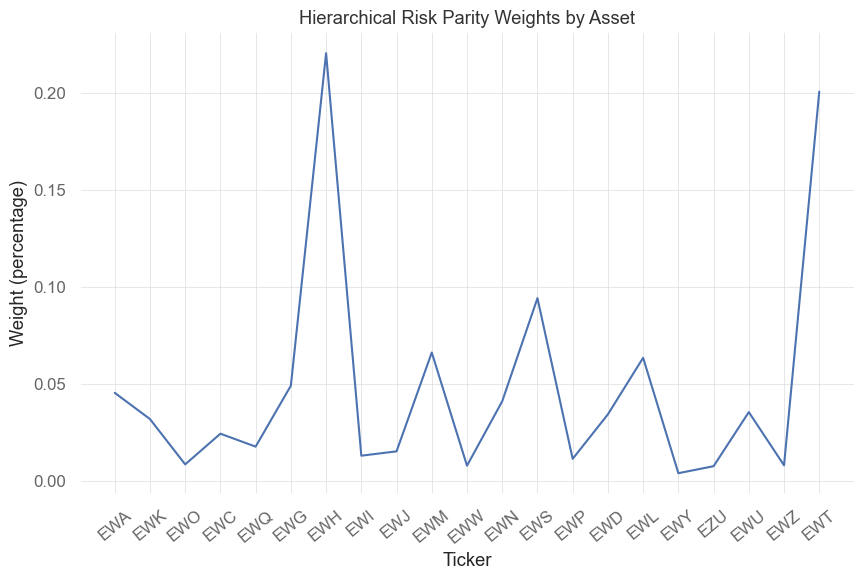

In [11]:
# get the asset weights from the recusrive bisection
weightsHRP = getRecBipart(covarianceMatrix, sortedMatrix)

# Plot the weights
xTicks = tickers
yTicks = weightsHRP.sort_index()
plt.xticks(rotation = 40)
plt.title('Hierarchical Risk Parity Weights by Asset')
plt.xlabel('Ticker')
plt.ylabel('Weight (percentage)')
plt.plot(xTicks,yTicks)

#### Results & Comparisons

In [55]:
# Since Markowitz Portfolios will likely not be implemented in my project,
# I used the PyPortfolioOptimization package to
# create simple markowitz portfolio to use as a benchmark
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

# use the historical return to get an estimate for the
# expected reutrn
expectedReturn = mean_historical_return(etfPricesTrain)
# use the covariance matrix to calculate the variance
# between the assets
variance = CovarianceShrinkage(etfPricesTrain).ledoit_wolf()

# Calculate the efficient frontier, which are the best portfolios
# per given risk characteristics
ef = EfficientFrontier(expectedReturn, variance)

# calculate weights ffrom the best portfolio
bestPortfolio = ef.max_sharpe()
weightsMP = ef.clean_weights()

##### Out-of-Sample Comparison

The below cells compute the return for each portfolio

In [56]:
# get the daily returns for each asset in the vaidation set
validationReturns = etfPricesVaidation.copy().pct_change()

In [57]:
# Hierarchical Risk Parity Portfolio
hRiskParity = validationReturns.copy()
for i in range(0, len(weightsHRP)):
    hRiskParity[i] *= weightsHRP[i]
hRiskParityPortfolio = hRiskParity.sum(axis=1)

In [58]:
# Equal Weight Portfolio
equalWeight = validationReturns.copy()
numAssets = len(etfPricesTrain.columns.values)
for i in range(0, numAssets):
    equalWeight[i] *= 1/numAssets
equalWeightPortfolio = equalWeight.sum(axis=1)

In [59]:
# Markowitz Portfolio
markowitz = validationReturns.copy()
for i in range(0, len(weightsMP)):
    markowitz[i] *= weightsMP[i]
markowitzPortfolio = markowitz.sum(axis=1)

Plot the cumulative return for each portfolio

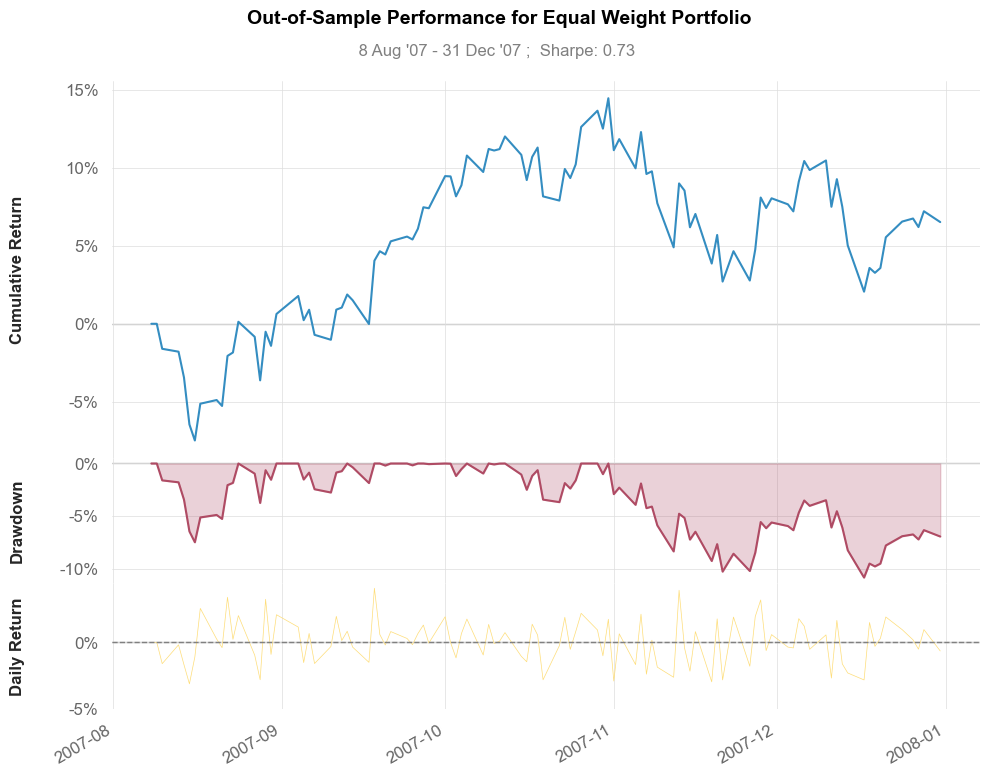

In [60]:
# here I make use of the QuantStats library, which
# also calculates sharpe ratio and drawdown
qs.plots.snapshot(equalWeightPortfolio, title='Out-of-Sample Performance for Equal Weight Portfolio', show=True)

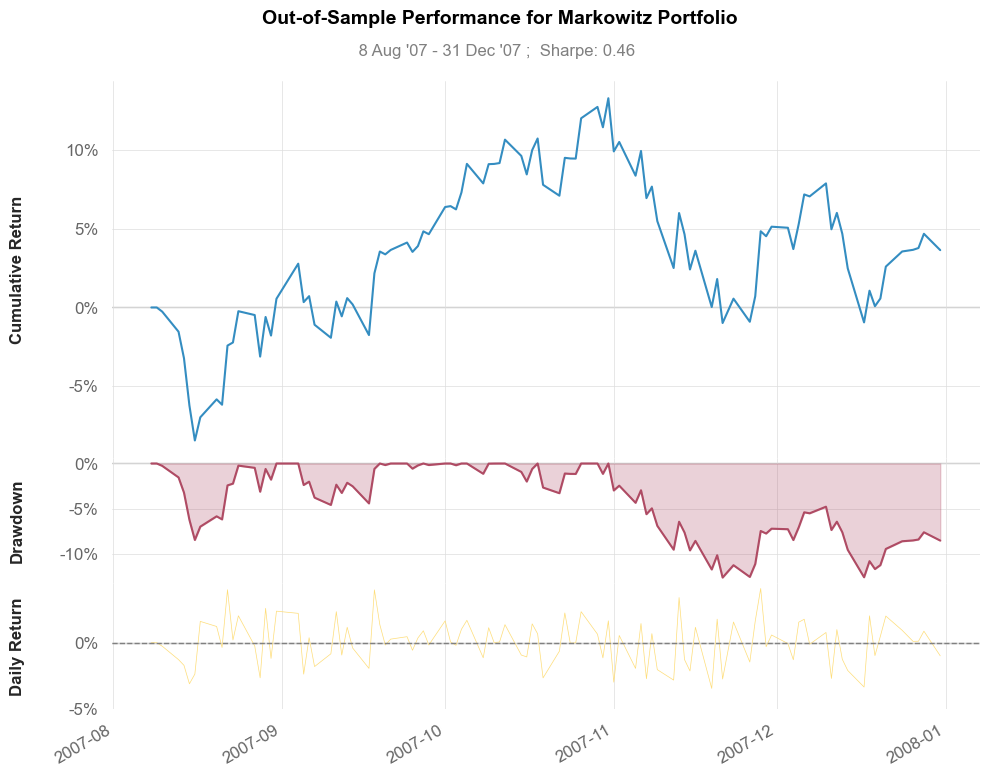

In [61]:
qs.plots.snapshot(markowitzPortfolio, title='Out-of-Sample Performance for Markowitz Portfolio', show=True)

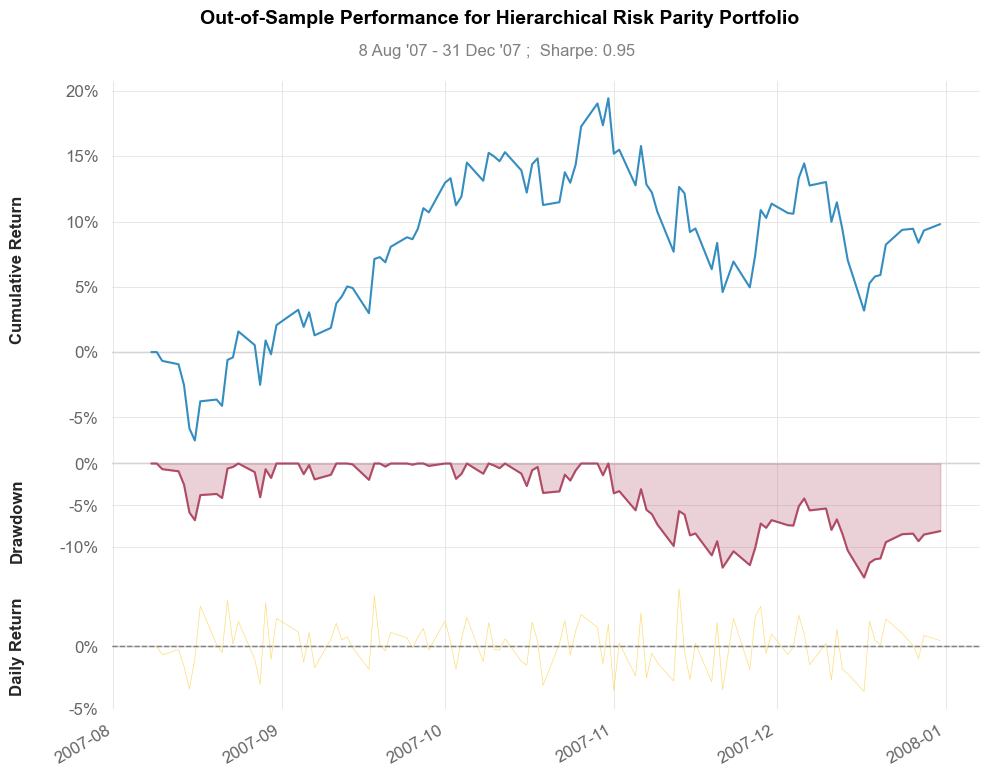

In [62]:
qs.plots.snapshot(hRiskParityPortfolio, title='Out-of-Sample Performance for Hierarchical Risk Parity Portfolio', show=True)

##### In-Sample Comparison

In [63]:
# define the training set returns
trainReturns = etfPricesTrain.copy().pct_change()

In [64]:
# Hierarchical Risk Parity Portfolio
hRiskParityIS = trainReturns.copy()
for i in range(0, len(weightsHRP)):
    hRiskParityIS[i] *= weightsHRP[i]
hRiskParityPortfolioIS = hRiskParityIS.sum(axis=1)

In [65]:
# Markowitz Portfolio
markowitzIS = trainReturns.copy()
for i in range(0, len(weightsMP)):
    markowitzIS[i] *= weightsMP[i]
markowitzPortfolioIS = markowitzIS.sum(axis=1)

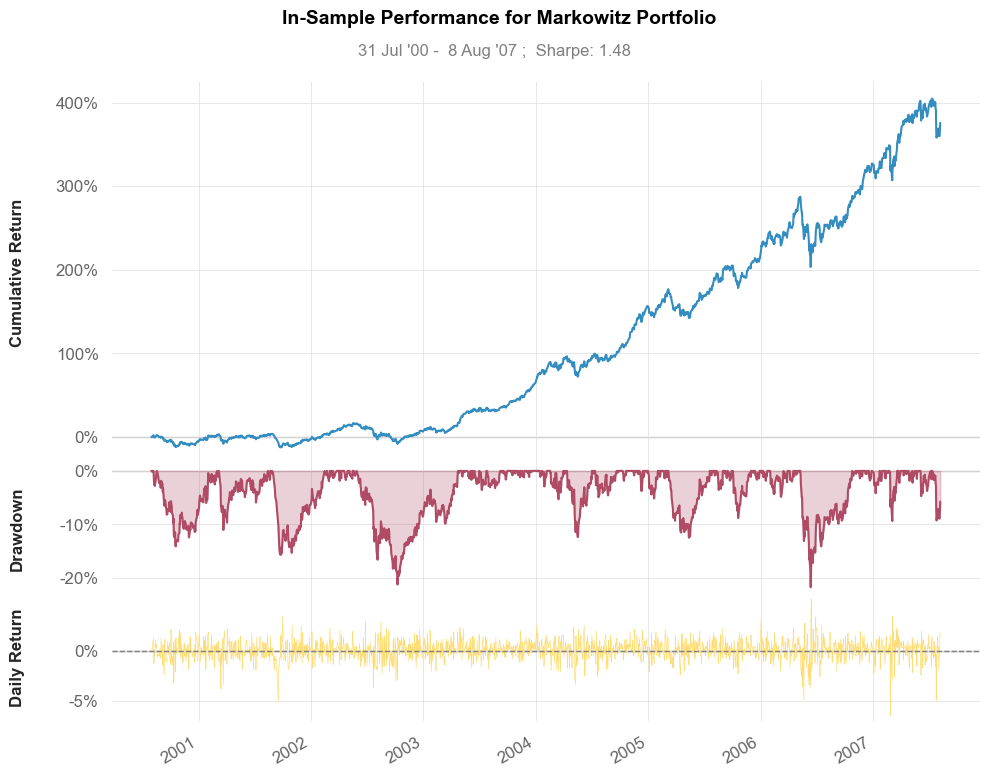

In [66]:
qs.plots.snapshot(markowitzPortfolioIS, title='In-Sample Performance for Markowitz Portfolio', show=True)

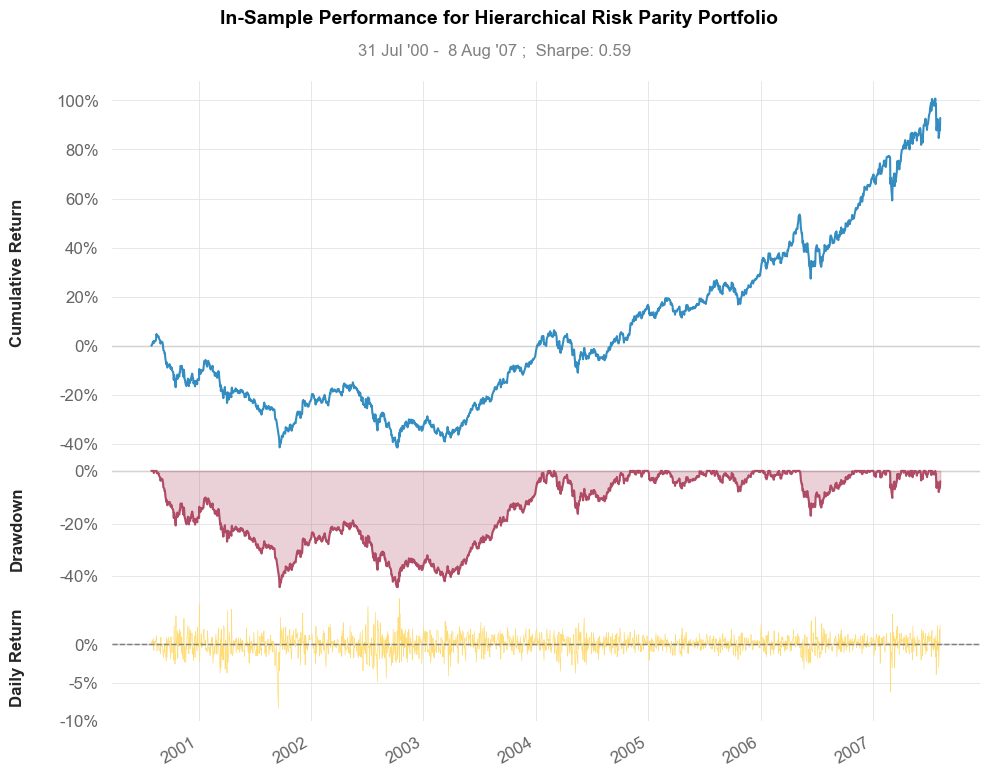

In [67]:
qs.plots.snapshot(hRiskParityPortfolioIS, title='In-Sample Performance for Hierarchical Risk Parity Portfolio', show=True)